# Demand forecasting with the Temporal Fusion Transformer

In this tutorial, we will train the :py:class:`~pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer`.

Loading the data

In [1]:
import gdown
import os
import warnings

warnings.filterwarnings("ignore")

# url = "https://drive.google.com/drive/folders/10fxlNGVm3xIJQLB958CU56T6UTGp_md0?usp=drive_link"
# gdown.download_folder(url, quiet=True, use_cookies=False)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-forecasting

In [4]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import torch

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting.models.deepar import DeepAR
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss

## Load data


The dataset is already in the correct format but misses some important features. Most importantly, we need to add a time index that is incremented by one for each time step

In [5]:
data = pd.read_csv("/content/drive/MyDrive/clean-data-consolidated.csv", sep=",")

In [6]:
# Uncomment if it takes too long to train
data = data.iloc[int(len(data)*0.4):]

### Create dataset and dataloaders

The next step is to convert the dataframe into a PyTorch Forecasting :py:class:`~pytorch_forecasting.data.timeseries.TimeSeriesDataSet`. Apart from telling the dataset which features are categorical vs continuous and which are static vs varying in time, we also have to decide how we normalise the data. Here, we standard scale each time series separately and indicate that values are always positive. Generally, the :py:class:`~pytorch_forecasting.data.encoders.EncoderNormalizer`, that scales dynamically on each encoder sequence as you train, is preferred to avoid look-ahead bias induced by normalisation. However, you might accept look-ahead bias if you are having troubles to find a reasonably stable normalisation, for example, because there are a lot of zeros in your data. Or you expect a more stable normalization in inference. In the later case, you ensure that you do not learn "weird" jumps that will not be present when running inference, thus training on a more realistic data set.


In [7]:
# Conversion de la colonne 'Date - Heure' en datetime
data["Date - Heure"] = pd.to_datetime(data["Date - Heure"])

# Création de l'index temporel (time_idx)
data["time_idx"] = data["Date - Heure"].rank(method="dense").astype(int)

In [8]:
data.columns

Index(['Date - Heure', 'Région', 'Consommation brute électricité (MW) - RTE',
       'Température (°C)', 'Nebulosité totale', 'heure', 'jour', 'mois',
       'jour_de_la_semaine', 'est_weekend', 'Température_norm',
       'Nebulosité_cat_Très Clair', 'Nebulosité_cat_Clair',
       'Nebulosité_cat_Partiellement Nuageux', 'Nebulosité_cat_Nuageux',
       'Nebulosité_cat_Très Nuageux', 'Haute_Consommation',
       'Consumption_lag_day_1', 'Consumption_lag_day_7',
       'Consumption_lag_week_1', 'Consumption_lag_week_4',
       'Consumption_lag_year_1', 'time_idx'],
      dtype='object')

In [11]:
time_varying_known_categoricals = ['heure', 'jour', 'mois',
       'jour_de_la_semaine', 'est_weekend']
time_varying_unknown_categoricals = ['Nebulosité_cat_Très Clair', 'Nebulosité_cat_Clair',
       'Nebulosité_cat_Partiellement Nuageux', 'Nebulosité_cat_Nuageux',
       'Nebulosité_cat_Très Nuageux', 'Haute_Consommation']

In [12]:
time_varying_known_reals = ['Consumption_lag_day_7', 'Consumption_lag_week_1', 'Consumption_lag_week_4', 'Consumption_lag_year_1', 'time_idx']
time_varying_unknown_reals = ['Température (°C)', 'Nebulosité totale', 'Température_norm', "Consommation brute électricité (MW) - RTE"]

In [14]:
max_prediction_length = 24
max_encoder_length = 24
training_cutoff = data["Date - Heure"].max() - pd.Timedelta(days=30*6)
training_cutoff = data[data["Date - Heure"] == training_cutoff]["time_idx"].values[0]
data[time_varying_known_categoricals] = data[time_varying_known_categoricals].astype(str)
data[time_varying_unknown_categoricals] = data[time_varying_unknown_categoricals].astype(str)

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Consommation brute électricité (MW) - RTE", #TODO
    group_ids=["Région"], #TODO
    min_encoder_length=int(max_encoder_length / 2), #TODO
    max_encoder_length=max_encoder_length, #TODO
    min_prediction_length=1, #TODO
    max_prediction_length=max_prediction_length,
    static_categoricals=["Région"], #TODO
    static_reals=[], #TODO
    time_varying_known_categoricals=time_varying_known_categoricals, #TODO
    time_varying_known_reals=time_varying_known_reals, # TODO
    time_varying_unknown_categoricals=time_varying_unknown_categoricals, #TODO
    time_varying_unknown_reals=time_varying_unknown_reals, # TODO
    target_normalizer=GroupNormalizer(
        groups=["Région"], #TODO,
        transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,  # Ajout de ce paramètre
)

validation = TimeSeriesDataSet.from_dataset(
    training, data[lambda x: x.time_idx > training_cutoff], predict=True, stop_randomization=True
)

batch_size = 512
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=4
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4
)

To learn more about the :py:class:`~pytorch_forecasting.data.timeseries.TimeSeriesDataSet`, visit its documentation or the :ref:`tutorial explaining how to pass datasets to models <passing-data>`.

## Create baseline model

Evaluating a :py:class:`~pytorch_forecasting.models.baseline.Baseline` model that predicts the next 6 months by simply repeating the last observed volume
gives us a simle benchmark that we want to outperform.

In [17]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
print("MAE", round(MAE()(baseline_predictions.output, baseline_predictions.y).item(), 3))
print("SMAPE", round(SMAPE()(baseline_predictions.output, baseline_predictions.y).item(), 3))

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE 686.257
SMAPE 0.062


# Train the Temporal Fusion Transformer

It is now time to create our :py:class:`~pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer` model. We train the model with PyTorch Lightning.

### Find optimal learning rate

Prior to training, you can identify the optimal learning rate with the [PyTorch Lightning learning rate finder](https://pytorch-lightning.readthedocs.io/en/latest/lr_finder.html).

In [18]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 13.6k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.03285320183364724
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.03285320183364724
INFO: Restoring states from the checkpoint path at /content/.lr_find_d5b901bb-b690-4cbc-a394-077aebacd7c9.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_d5b901bb-b690-4cbc-a394-077aebacd7c9.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_d5b901bb-b690-4cbc-a394-077aebacd7c9.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_d5b901bb-b690-4cbc-a394-077aebacd7c9.ckpt


suggested learning rate: 0.03285320183364724


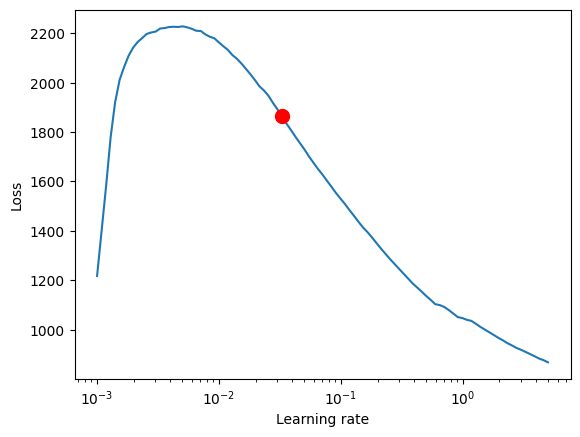

In [19]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=5.0,
    min_lr=1e-3,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### Train model

In [20]:
# configure network and trainer
# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
# lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10,
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.05,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    #  log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 13.6k


In [21]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 633   
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.0 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initia

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Exception in thread Thread-15:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/tqdm/_monitor.py", line 69, in run
    instances = self.get_instances()
  File "/usr/local/lib/python3.10/dist-packages/tqdm/_monitor.py", line 49, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "/usr/lib/python3.10/_weakrefset.py", line 97, in copy
    return self.__class__(self)
  File "/usr/lib/python3.10/_weakrefset.py", line 51, in __init__
    self.update(data)
  File "/usr/lib/python3.10/_weakrefset.py", line 124, in update
    for element in other:
  File "/usr/lib/python3.10/_weakrefset.py", line 65, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Evaluate performance

PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.

In [22]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

After training, we can make predictions with :py:meth:`~pytorch_forecasting.models.base_model.BaseModel.predict`. The method allows very fine-grained control over what it returns so that, for example, you can easily match predictions to your pandas dataframe. See its documentation for details. We evaluate the metrics on the validation dataset and a couple of examples to see how well the model is doing. Given that we work with only 21 000 samples the results are very reassuring and can compete with results by a gradient booster. We also perform better than the baseline model. Given the noisy data, this is not trivial.

In [23]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
print("MAE", round(MAE()(predictions.output, predictions.y).item(), 3))
print("SMAPE", round(SMAPE()(predictions.output, predictions.y).item(), 3))

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


MAE 436.269
SMAPE 0.046


We can now also look at sample predictions directly which we plot with :py:meth:`~pytorch_forecasting.models.base_model.BaseModel.plot_prediction`. As you can see from the figures below, forecasts look rather accurate. If you wonder, the grey lines denote the amount of attention the model pays to different points in time when making the prediction. This is a special feature of the Temporal Fusion Transformer.

In [24]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


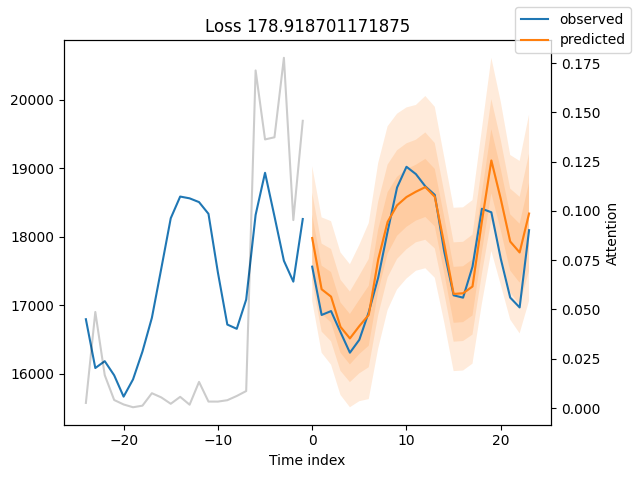

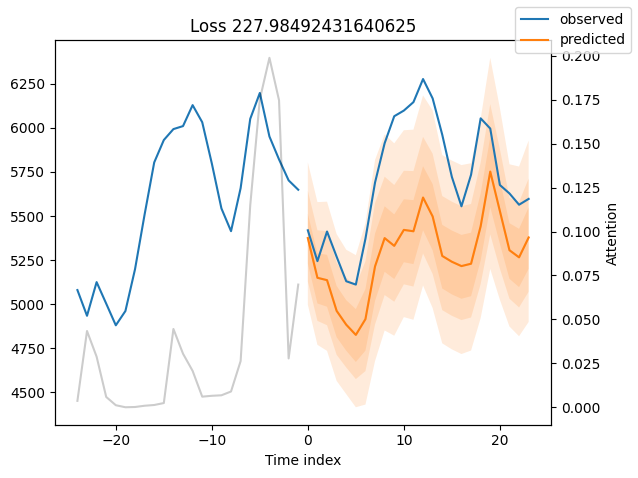

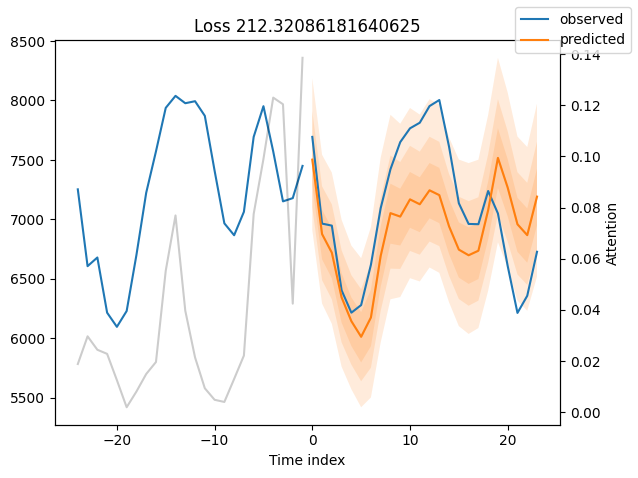

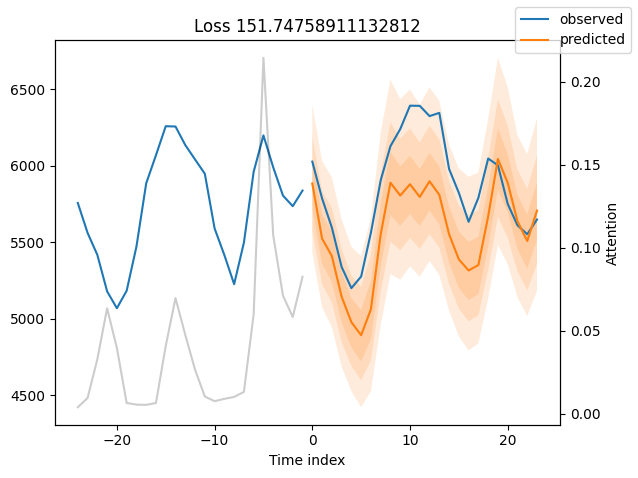

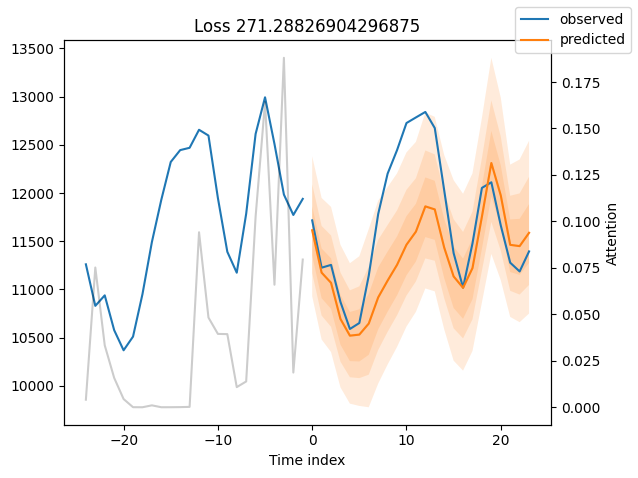

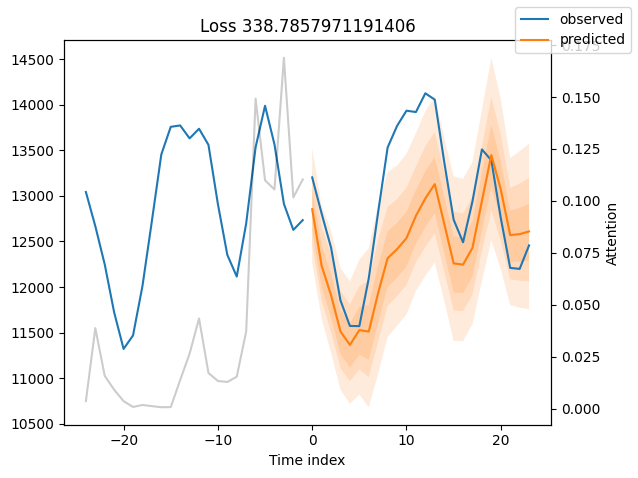

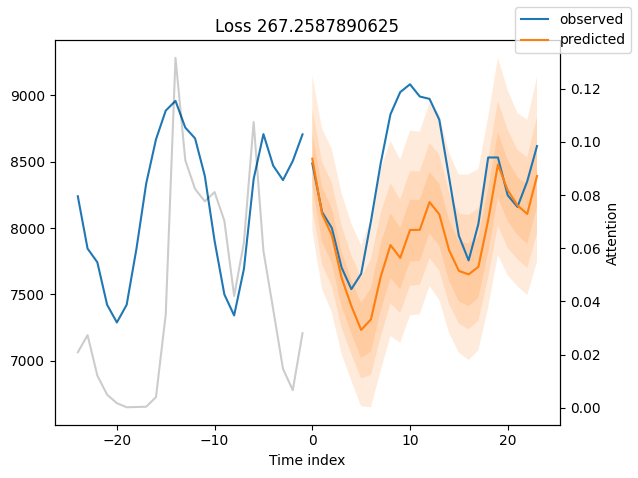

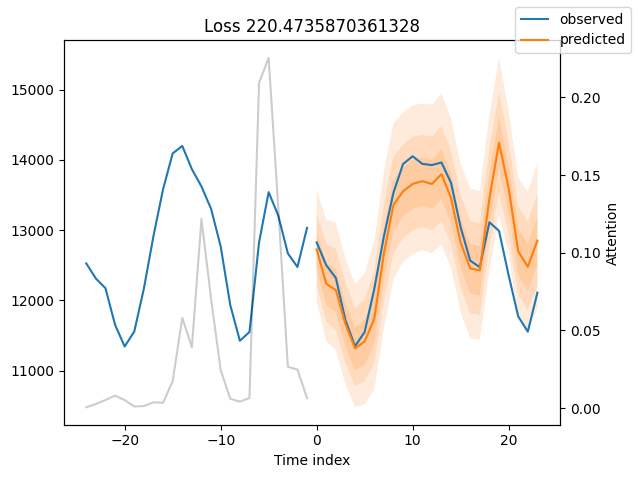

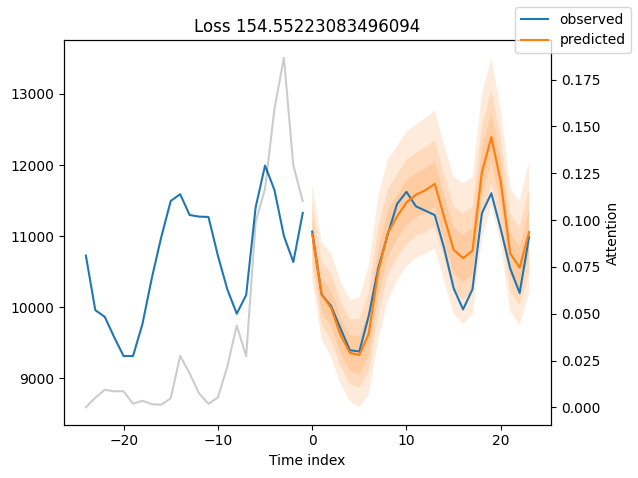

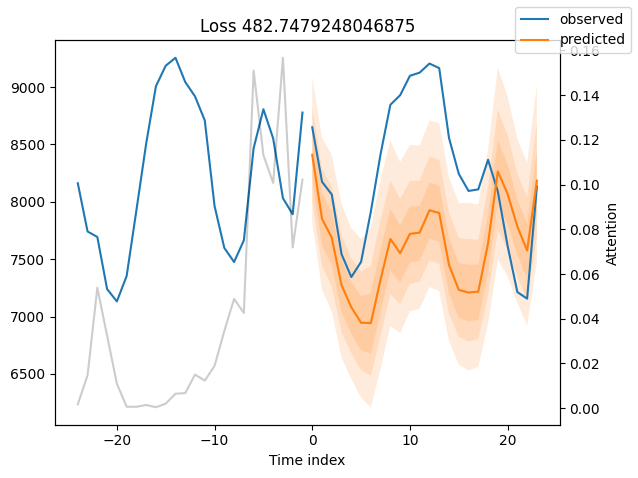

In [25]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )